In [1]:
from pyquil.quil import *
from pyquil.api import get_qc
from pyquil.gates import *
from pyquil.latex import display, to_latex
from pyquil.simulation.tools import lifted_gate, program_unitary, lifted_gate_matrix

In [2]:
from pyquil.simulation.tools import lifted_gate, program_unitary, lifted_gate_matrix

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 3-CNOT recipe
![alt text](3cnot.png "Title")


In [4]:
def random_rotation(qubit):
    phi = np.random.uniform(0, 2*np.pi)
    theta = np.random.uniform(0, np.pi)
    return Program( RX(-np.pi/2, qubit = qubit), RZ(theta, qubit = qubit),
                    RX(np.pi/2, qubit = qubit), RZ(phi, qubit = qubit) )
def random_universal_two_qubit_gate(qubit_0, qubit_1):
    prog = Program(random_rotation(qubit_0), random_rotation(qubit_1))
    for i in range(3):
        prog += Program( CNOT(control=qubit_0,  target=qubit_1),
                        random_rotation(qubit_0), random_rotation(qubit_1) )
    return prog

In [5]:
# print(to_latex(random_universal_two_qubit_gate(0,1)))

In [6]:
qc = get_qc("9q-square-qvm")

ep = qc.compile(random_universal_two_qubit_gate(0,1), to_native_gates = True, optimize  = True)
print(len(ep))

39


In [7]:
# print(to_latex(ep))

In [8]:
print( qc.compile(Program(H(0))) )

RZ(pi) 0
RX(pi/2) 0
RZ(pi/2) 0
RX(-pi/2) 0
HALT



# Programmable recipe
![alt text](rotation_definition.png "Title")
$$R(\theta, \phi) = R_z(-\frac{\phi}{2})R_y(\theta)R_z(\frac{\phi}{2})$$
![alt text](programmble_decomposition.png "Title")

In [9]:
# print( qc.compile(Program(PHASE(- np.pi/2, qubit=0), CNOT(control=0, target=1))) )

In [10]:
G = Program(PHASE(- np.pi/2, qubit=0), CNOT(control=0, target=1))

$$R(\theta, \phi) = R_z(-\frac{\phi}{2})R_y(\theta)R_z(\frac{\phi}{2})\\
U(2) = R(\theta, \phi) R_z(\phi_z)\\
or\\
U(2) = R_z(\theta) R_y(\phi) R_z(\psi)
$$

In [11]:
def arbitary_single_qubit_circuit(theta, phi, si, qubit):
    return Program( RZ(si, qubit = qubit), RY(phi, qubit = qubit), RZ(theta, qubit = qubit) )

def r_theta_phi_rotation(theta, phi, qubit):
    return arbitary_single_qubit_circuit( - phi/2, theta, phi/2, qubit)

In [12]:
def give_random_single_qubit_gate(qubit):
    theta, si = np.random.uniform(0,2*np.pi, size = 2)
    
    phi_range = np.linspace(0,np.pi)
    p_phi = np.sin(phi_range) / np.sum(np.sin(phi_range))
    phi = np.random.choice(phi_range, p = p_phi)
    return arbitary_single_qubit_circuit(theta, phi, si, qubit = qubit)

def normalized_abs_angle_dist(angle_range):
    dist = np.pi - np.abs( np.pi - angle_range )
    dist /= np.sum(dist)
    return dist

def give_random_two_quibt_circuit(qubits):
    a,b,c,d = [give_random_single_qubit_gate(qubit=qubit) for _ in range(2) for qubit in qubits]
    
    angles_range = np.linspace(0,2*np.pi)
    alpha, beta, delta = np.random.choice(angles_range, p = normalized_abs_angle_dist(angles_range),
                                          size = 3)
    
    prog = Program(a, b )
    prog += Program(G,  r_theta_phi_rotation(alpha, 0, qubit =0), 
                    r_theta_phi_rotation(3*np.pi/2,0, qubit =1), G)
    prog += Program( r_theta_phi_rotation(beta, np.pi/2, qubit = 0), 
                    r_theta_phi_rotation(3*np.pi/2, delta, qubit = 1), G)
    prog += Program(c, d )
    return prog

In [15]:
program_unitary(give_random_two_quibt_circuit([0,1]), n_qubits=2)

array([[-0.3076312 +0.58956584j,  0.07110725-0.23841697j,
         0.31939289+0.21146415j,  0.39090812-0.44310068j],
       [-0.37977637+0.1225817j ,  0.05089483+0.34171602j,
        -0.31509415+0.36186889j, -0.61132831-0.3426774j ],
       [-0.23362813+0.49749744j,  0.04112167-0.22615995j,
        -0.54281331-0.52954231j, -0.05665748+0.25846366j],
       [ 0.29242114-0.10451255j,  0.87274287-0.06497351j,
        -0.20826501-0.06783818j,  0.06480645-0.29238524j]])

In [18]:
sample = give_random_two_quibt_circuit([0,1])
print( qc.compile( sample ) , len(sample), len(qc.compile( sample )))

RZ(-1.0966237364029485) 0
RX(pi/2) 0
RZ(1.8564231145730823) 0
RX(-pi/2) 0
RZ(-0.3185563002975492) 0
RZ(-3.072883842603613) 1
RX(pi/2) 1
RZ(2.5216622162645073) 1
RX(-pi/2) 1
RZ(1.0155678973901865) 1
XY(pi) 0 1
RX(pi/2) 0
RZ(0.09381466023791601) 0
RX(-pi/2) 0
RZ(-3*pi/2) 0
RZ(pi/2) 1
RX(pi/2) 1
RZ(pi/2) 1
RX(-pi/2) 1
RZ(-2.9177996543986855) 1
XY(pi) 0 1
RX(pi/2) 0
RZ(pi/2) 0
RX(-pi/2) 0
RX(pi/2) 1
RZ(1.5604594396269613) 1
RX(-pi/2) 1
XY(pi) 0 1
RZ(0.037581240243370666) 0
RX(pi/2) 0
RZ(1.9101470520523713) 0
RX(-pi/2) 0
RZ(1.5243388247684868) 0
RZ(-2.0785277572861407) 1
RX(pi/2) 1
RZ(1.5566527277044568) 1
RX(-pi/2) 1
RZ(1.1191001480485954) 1
HALT
 30 39


In [14]:
# program_unitary(give_random_single_qubit_gate(0), n_qubits = 1)

# Visualization
## single-qubit

In [10]:
num_samples = 2021

single_qubit_unitary_samples = [program_unitary(give_random_single_qubit_gate(qubit=0), n_qubits = 1) for _ in range(num_samples)]

In [12]:
single_zero_state_density_matrix = np.array([[1,0],[0,0]])
single_final_states = np.array( [np.dot( np.dot(u,single_zero_state_density_matrix), u.conj().T ) for u in single_qubit_unitary_samples] )

In [13]:
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# Used the mixed state simulator so we could have the density matrix for this part!
def convert_to_bloch_vector(rho):
    """Convert a density matrix to a Bloch vector."""
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    return [ax, ay, az]

In [14]:
single_qubit_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in single_final_states])

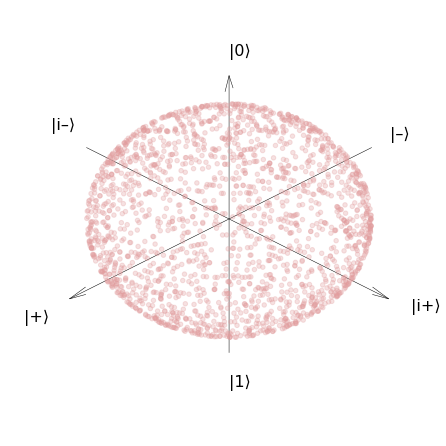

In [44]:
def plot_bloch_sphere(bloch_vectors):
    """ Helper function to plot vectors on a sphere."""
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    ax.grid(False)
    ax.set_axis_off()
    ax.view_init(30, 45)
    ax.dist = 7

    # Draw the axes (source: https://github.com/matplotlib/matplotlib/issues/13575)
    x, y, z = np.array([[-1.5,0,0], [0,-1.5,0], [0,0,-1.5]])
    u, v, w = np.array([[3,0,0], [0,3,0], [0,0,3]])
    ax.quiver(x, y, z, u, v, w, arrow_length_ratio=0.05, color="black", linewidth=0.5)

    ax.text(0, 0, 1.7, r"|0⟩", color="black", fontsize=16)
    ax.text(0, 0, -1.9, r"|1⟩", color="black", fontsize=16)
    ax.text(1.9, 0, 0, r"|+⟩", color="black", fontsize=16)
    ax.text(-1.7, 0, 0, r"|–⟩", color="black", fontsize=16)
    ax.text(0, 1.7, 0, r"|i+⟩", color="black", fontsize=16)
    ax.text(0,-1.9, 0, r"|i–⟩", color="black", fontsize=16)

    ax.scatter(
        bloch_vectors[:,0], bloch_vectors[:,1], bloch_vectors[:, 2], c='#e29d9e', alpha=0.3
    )
#     ax.scatter(bloch_vectors[:,0], bloch_vectors[:,1], bloch_vectors[:,1]* 0, c = 'b')

plot_bloch_sphere(single_qubit_bloch_vectors)

## Two qubits

In [42]:
num_samples = 2021

two_qubit_unitary_samples = [program_unitary(give_random_two_quibt_circuit([0,1]), n_qubits = 2) for _ in range(num_samples)]

In [43]:
two_zero_state_density_matrix = np.kron( np.array([[1,0],[0,0]]) , np.array([[1,0],[0,0]]) )
two_final_states = np.array( [np.dot( np.dot(u,two_zero_state_density_matrix), u.conj().T ) for u in two_qubit_unitary_samples] )

In [44]:
# X_I = np.kron( np.array([[0, 1], [1, 0]]), np.eye(2) )
# Y_I = np.kron( np.array([[0, -1j], [1j, 0]]), np.eye(2) )
# Z_I = np.kron( np.array([[1, 0], [0, -1]]), np.eye(2) )

# # Used the mixed state simulator so we could have the density matrix for this part!
# def convert_to_bloch_vector(rho):
#     """Convert a density matrix to a Bloch vector."""
#     ax = np.trace(np.dot(rho, X_I)).real
#     ay = np.trace(np.dot(rho, Y_I)).real
#     az = np.trace(np.dot(rho, Z_I)).real
#     return [ax, ay, az]

In [45]:
# I_X = np.kron( np.eye(2), np.array([[0, 1], [1, 0]]) )
# I_Y = np.kron( np.eye(2), np.array([[0, -1j], [1j, 0]]) )
# I_Z = np.kron( np.eye(2), np.array([[1, 0], [0, -1]]) )

# # Used the mixed state simulator so we could have the density matrix for this part!
# def convert_to_bloch_vector(rho):
#     """Convert a density matrix to a Bloch vector."""
#     ax = np.trace(np.dot(rho, I_X)).real
#     ay = np.trace(np.dot(rho, I_Y)).real
#     az = np.trace(np.dot(rho, I_Z)).real
#     return [ax, ay, az]

In [46]:
X_Y = np.kron( np.array([[0, 1], [1, 0]]), np.array([[0, -1j], [1j, 0]]) )
Y_Y = np.kron( np.array([[0, -1j], [1j, 0]]), np.array([[0, -1j], [1j, 0]]) )
Z_Y = np.kron( np.array([[1, 0], [0, -1]]), np.array([[0, -1j], [1j, 0]]) )

# Used the mixed state simulator so we could have the density matrix for this part!
def convert_to_bloch_vector(rho):
    """Convert a density matrix to a Bloch vector."""
    ax = np.trace(np.dot(rho, X_Y)).real
    ay = np.trace(np.dot(rho, Y_Y)).real
    az = np.trace(np.dot(rho, Z_Y)).real
    return [ax, ay, az]

In [47]:
two_qubit_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in two_final_states])

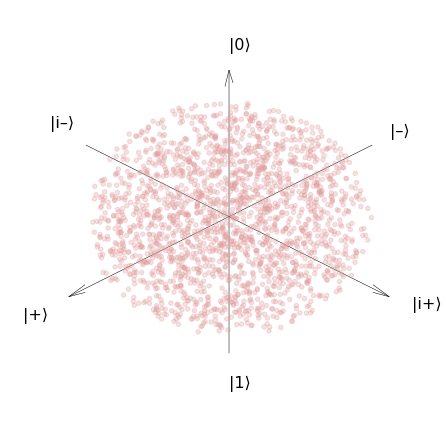

In [48]:
def plot_bloch_sphere(bloch_vectors):
    """ Helper function to plot vectors on a sphere."""
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    ax.grid(False)
    ax.set_axis_off()
    ax.view_init(30, 45)
    ax.dist = 7

    # Draw the axes (source: https://github.com/matplotlib/matplotlib/issues/13575)
    x, y, z = np.array([[-1.5,0,0], [0,-1.5,0], [0,0,-1.5]])
    u, v, w = np.array([[3,0,0], [0,3,0], [0,0,3]])
    ax.quiver(x, y, z, u, v, w, arrow_length_ratio=0.05, color="black", linewidth=0.5)

    ax.text(0, 0, 1.7, r"|0⟩", color="black", fontsize=16)
    ax.text(0, 0, -1.9, r"|1⟩", color="black", fontsize=16)
    ax.text(1.9, 0, 0, r"|+⟩", color="black", fontsize=16)
    ax.text(-1.7, 0, 0, r"|–⟩", color="black", fontsize=16)
    ax.text(0, 1.7, 0, r"|i+⟩", color="black", fontsize=16)
    ax.text(0,-1.9, 0, r"|i–⟩", color="black", fontsize=16)

    ax.scatter(
        bloch_vectors[:,0], bloch_vectors[:,1], bloch_vectors[:, 2], c='#e29d9e', alpha=0.3
    )
#     ax.scatter(bloch_vectors[:,0], bloch_vectors[:,1], bloch_vectors[:,1]* 0, c = 'b')
#     plt.figure()
#     xy_distance_to_origin = np.sqrt( bloch_vectors[:,0]**2 + bloch_vectors[:,1]**2 )
#     plt.hist(xy_distance_to_origin, density=True)
#     plt.hist(bloch_vectors[:,0])

plot_bloch_sphere(two_qubit_bloch_vectors)

In [49]:
r_bloch_vectors = np.sqrt( two_qubit_bloch_vectors[:,0]**2 + two_qubit_bloch_vectors[:,1]**2 + two_qubit_bloch_vectors[:,2]**2)

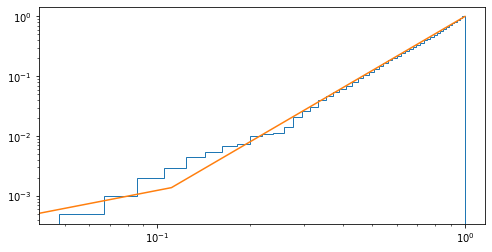

In [50]:
n_bins = 50

fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
ax.hist(r_bloch_vectors, n_bins, density=True, histtype='step',
         cumulative=True, label='Empirical')
ax.set_yscale('log')
ax.set_xscale('log')
ax.plot(np.linspace(0,1,10), np.linspace(0,1,10)**3)
plt.show()

# Rotation recipe
[alt text](rotation_decomposition.png "Title")

In [29]:
# def arbitary_single_quibt_circuit(theta, phi, si, qubit):
#     return Program( RZ(theta, qubit = qubit), RY(phi, qubit = qubit), RZ(si, qubit = qubit) )

# def give_random_single_qubit_gate(qubit):
#     theta, si = np.random.uniform(0,2*np.pi, size = 2)
    
#     phi_range = np.linspace(0,np.pi)
#     p_phi = np.sin(phi_range) / np.sum(np.sin(phi_range))
#     phi = np.random.choice(phi_range, p = p_phi)
#     return arbitary_single_quibt_circuit(theta, phi, si, qubit = qubit)

# def give_random_two_quibt_circuit(qubits):
#     a,b,c,d = [give_random_single_qubit_gate(qubit=qubit) for _ in range(2) for qubit in qubits]

#     alpha, beta, delta = np.random.uniform(0,2*np.pi, size = 3)
    
#     prog = Program(c, d )
#     prog += Program( CNOT(control = qubits[0], target=qubits[1]), RZ(delta, qubit=qubits[0]), RY(beta, qubit=qubits[1]) )
#     prog += Program( CNOT(control = qubits[1], target = qubits[0]), RY(alpha, qubit=qubits[1]), CNOT(control = qubits[0], target=qubits[1]) )
#     prog += Program(a, b )
#     return prog

In [80]:
print(qc.compile(give_random_two_quibt_circuit([0,1]), to_native_gates=True))

RZ(2.6949098814415158) 0
RX(pi/2) 0
RZ(0.9617120368132028) 0
RX(-pi/2) 0
RZ(0.520336749108421) 0
RZ(-2.9100190726452535) 1
RX(pi/2) 1
RZ(1.859309937838858) 1
RX(-pi/2) 1
RZ(2.318411174406353) 1
XY(pi) 0 1
RX(pi/2) 0
RZ(0.8428705267987237) 0
RX(-pi/2) 0
RX(pi/2) 1
RZ(0.6155351113847428) 1
RX(-pi/2) 1
CZ 0 1
RZ(-1.9818386505092072) 0
RX(pi/2) 0
RZ(1.0258261726007492) 0
RX(-pi/2) 0
RZ(-3.4704797436294896) 0
RZ(-2.832519538216369) 1
RX(pi/2) 1
RZ(2.051652345201497) 1
RX(-pi/2) 1
RZ(-0.9677913934030862) 1
HALT

